# Day 6: Volatility Trading Strategies

---

### 🎯 Learning Objectives
- Build volatility-based trading strategies
- Implement volatility timing
- Create volatility regime strategies
- Understand volatility risk premium

---

### 📈 Why Volatility Strategies Matter

| **Tactical allocation** | Reduce equity in stress |

**Volatility is an asset class of its own.** You can trade it directly.| **Factor investing** | Low vol as a factor |

| **Options strategies** | Sell rich vol, buy cheap |

### Strategies Covered| **Risk parity** | Equal risk contribution |

- Low volatility anomaly|-------------|-------------|

- Volatility regime switching| Application | How It Helps |

- Volatility targeting

- Volatility risk premium harvesting### Trading Applications



### Strategy Overview| VRP harvesting | Sell overpriced vol | Tail risk |

| Vol targeting | Constant risk, varying position | Transaction costs |

| Strategy | Idea | Risk || Vol timing | Reduce exposure in high vol | Whipsaw |

|----------|------|------|| Low vol anomaly | Low vol stocks have higher Sharpe | Crowded trade |

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from arch import arch_model
from scipy import stats
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252  # Trading days per year

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1256 days


## 1. Low Volatility Anomaly

| Benchmarking | Managers chase high beta for tracking |

### 🎯 The Paradox| Leverage constraints | Can't lever low vol, so undervalued |

| Lottery preference | Investors overpay for high vol |

**Low volatility stocks have HIGHER risk-adjusted returns.**|-------------|----------|

| Explanation | Mechanism |

| Expectation | Reality |

|-------------|--------|### Why Does It Work?

| High risk = high return | Often not true |

| Beta = return driver | Beta is penalized || Efficient markets | Low vol anomaly persists |

In [2]:
# Low volatility stocks tend to outperform on risk-adjusted basis
# Strategy: Long low vol, short high vol

lookback = 60  # 60-day volatility

# Calculate rolling volatility for all stocks
rolling_vol = returns.rolling(lookback).std() * np.sqrt(TRADING_DAYS)

# Remove any assets with too many NaNs
valid_assets = rolling_vol.columns[rolling_vol.isna().sum() < len(rolling_vol) * 0.3]
rolling_vol = rolling_vol[valid_assets]
asset_returns = returns[valid_assets]

# Rank stocks by volatility each day
vol_rank = rolling_vol.rank(axis=1, pct=True)

# Low vol portfolio: bottom 20%
low_vol_mask = vol_rank <= 0.2

# High vol portfolio: top 20%
high_vol_mask = vol_rank >= 0.8

# Equal weight portfolios (handle division by zero)
low_vol_count = low_vol_mask.shift(1).sum(axis=1).replace(0, np.nan)
high_vol_count = high_vol_mask.shift(1).sum(axis=1).replace(0, np.nan)

low_vol_returns = (asset_returns * low_vol_mask.shift(1)).sum(axis=1) / low_vol_count
high_vol_returns = (asset_returns * high_vol_mask.shift(1)).sum(axis=1) / high_vol_count
spread_returns = low_vol_returns - high_vol_returns

# Clean NaN
low_vol_returns = low_vol_returns.dropna()
high_vol_returns = high_vol_returns.dropna()
spread_returns = spread_returns.dropna()

print("\n" + "="*60)
print("LOW VOLATILITY ANOMALY RESULTS")
print("="*60)


LOW VOLATILITY ANOMALY RESULTS


In [3]:
# Performance analysis
def portfolio_stats(returns, name):
    ann_ret = returns.mean() * TRADING_DAYS * 100
    ann_vol = returns.std() * np.sqrt(TRADING_DAYS) * 100
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    cum_ret = (1 + returns).cumprod().iloc[-1] - 1
    max_dd = ((1 + returns).cumprod() / (1 + returns).cumprod().cummax() - 1).min()
    
    return {
        'Portfolio': name,
        'Ann. Return (%)': ann_ret,
        'Ann. Vol (%)': ann_vol,
        'Sharpe': sharpe,
        'Total Return (%)': cum_ret * 100,
        'Max Drawdown (%)': max_dd * 100
    }

results = [
    portfolio_stats(low_vol_returns, 'Low Vol (Bottom 20%)'),
    portfolio_stats(high_vol_returns, 'High Vol (Top 20%)'),
    portfolio_stats(spread_returns, 'Long/Short Spread')
]

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

           Portfolio  Ann. Return (%)  Ann. Vol (%)    Sharpe  Total Return (%)  Max Drawdown (%)
Low Vol (Bottom 20%)        11.809979     24.091915  0.490205         52.550504        -31.120830
  High Vol (Top 20%)        30.163216     26.529752  1.136958        254.021726        -32.432340
   Long/Short Spread       -18.353237     25.320206 -0.724845        -64.078115        -73.454539


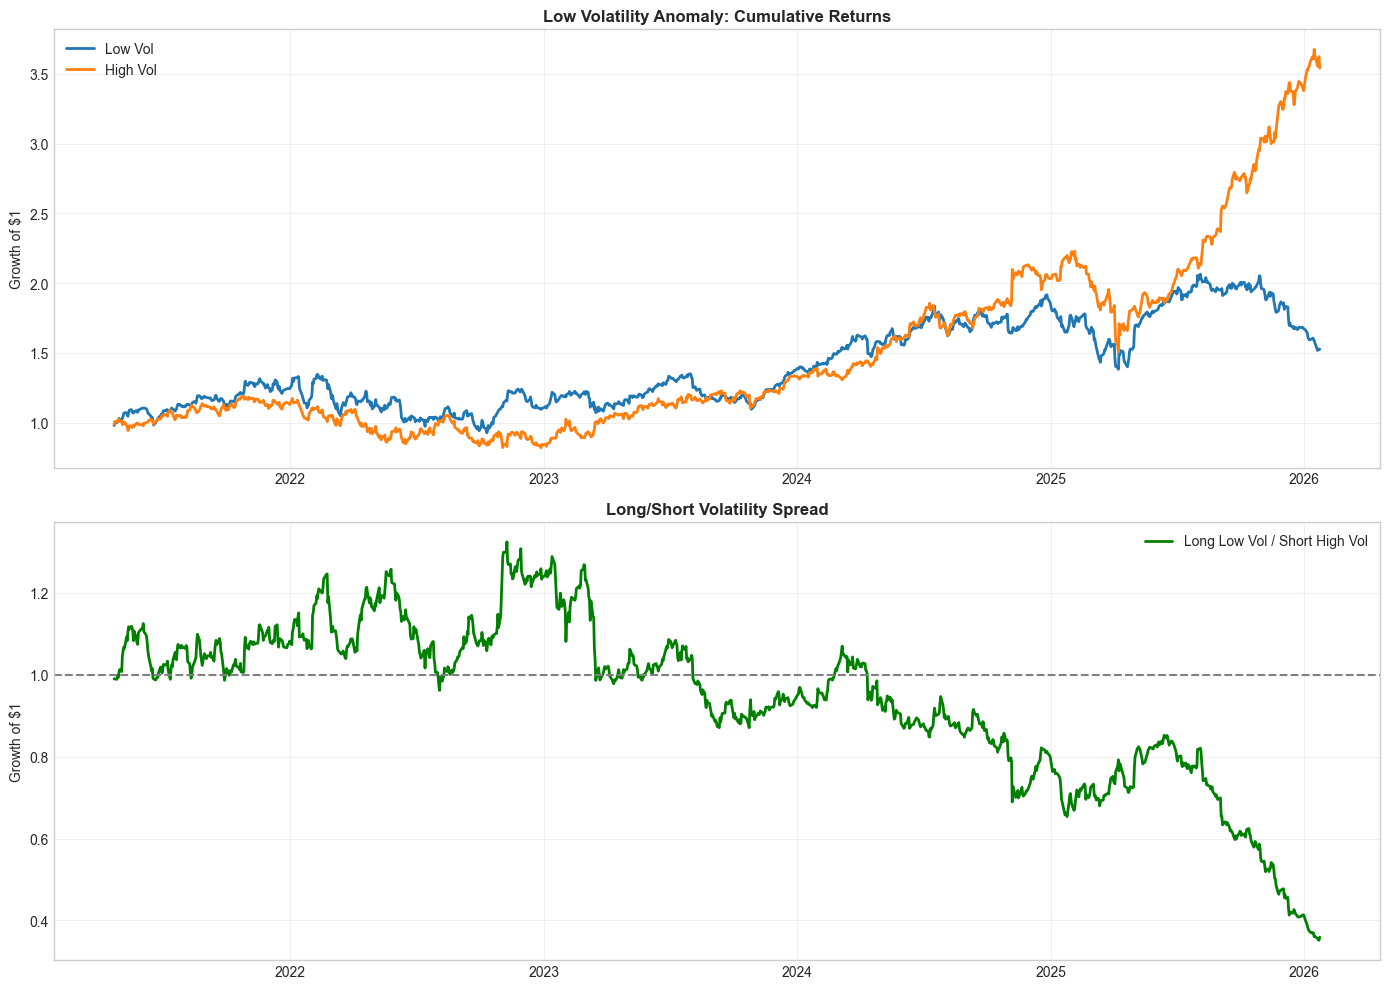

In [4]:
# Plot cumulative returns
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

ax1 = axes[0]
ax1.plot((1 + low_vol_returns).cumprod(), label='Low Vol', linewidth=2)
ax1.plot((1 + high_vol_returns).cumprod(), label='High Vol', linewidth=2)
ax1.set_title('Low Volatility Anomaly: Cumulative Returns', fontweight='bold')
ax1.set_ylabel('Growth of $1')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot((1 + spread_returns).cumprod(), label='Long Low Vol / Short High Vol', color='green', linewidth=2)
ax2.axhline(1, color='gray', linestyle='--')
ax2.set_title('Long/Short Volatility Spread', fontweight='bold')
ax2.set_ylabel('Growth of $1')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Volatility Regime Strategy

In [5]:
# Strategy: Reduce exposure in high volatility regimes
aapl_returns = returns['AAPL'].dropna()
aapl_vol = aapl_returns.rolling(20).std() * np.sqrt(TRADING_DAYS)

# Define volatility regimes
vol_percentile = aapl_vol.rolling(252).apply(lambda x: stats.percentileofscore(x, x.iloc[-1]))

# Regime classification
low_vol_regime = vol_percentile < 30
high_vol_regime = vol_percentile > 70
med_vol_regime = ~low_vol_regime & ~high_vol_regime

print("\n" + "="*60)
print("VOLATILITY REGIME ANALYSIS")
print("="*60)
print(f"Low Vol Regime (<30th %ile):  {low_vol_regime.sum()} days ({low_vol_regime.mean()*100:.1f}%)")
print(f"Med Vol Regime (30-70th %ile): {med_vol_regime.sum()} days ({med_vol_regime.mean()*100:.1f}%)")
print(f"High Vol Regime (>70th %ile): {high_vol_regime.sum()} days ({high_vol_regime.mean()*100:.1f}%)")


VOLATILITY REGIME ANALYSIS
Low Vol Regime (<30th %ile):  353 days (28.1%)
Med Vol Regime (30-70th %ile): 554 days (44.1%)
High Vol Regime (>70th %ile): 348 days (27.7%)


In [6]:
# Strategy weights based on regime
weights = pd.Series(index=aapl_returns.index, dtype=float)
weights[low_vol_regime] = 1.5   # Lever up in low vol
weights[med_vol_regime] = 1.0   # Normal exposure
weights[high_vol_regime] = 0.5  # Reduce in high vol

# Shift weights to avoid look-ahead
weights = weights.shift(1)

# Strategy returns
regime_strategy_returns = aapl_returns * weights
regime_strategy_returns = regime_strategy_returns.dropna()
buy_hold_returns = aapl_returns.loc[regime_strategy_returns.index]

print("\n" + "="*60)
print("REGIME STRATEGY vs BUY-AND-HOLD")
print("="*60)

regime_results = [
    portfolio_stats(buy_hold_returns, 'Buy & Hold SPY'),
    portfolio_stats(regime_strategy_returns, 'Vol Regime Strategy')
]
print(pd.DataFrame(regime_results).to_string(index=False))


REGIME STRATEGY vs BUY-AND-HOLD
          Portfolio  Ann. Return (%)  Ann. Vol (%)   Sharpe  Total Return (%)  Max Drawdown (%)
     Buy & Hold SPY        15.399469     27.684284 0.556253         77.985751        -33.360523
Vol Regime Strategy        14.316761     25.288914 0.566128         73.947909        -28.283509


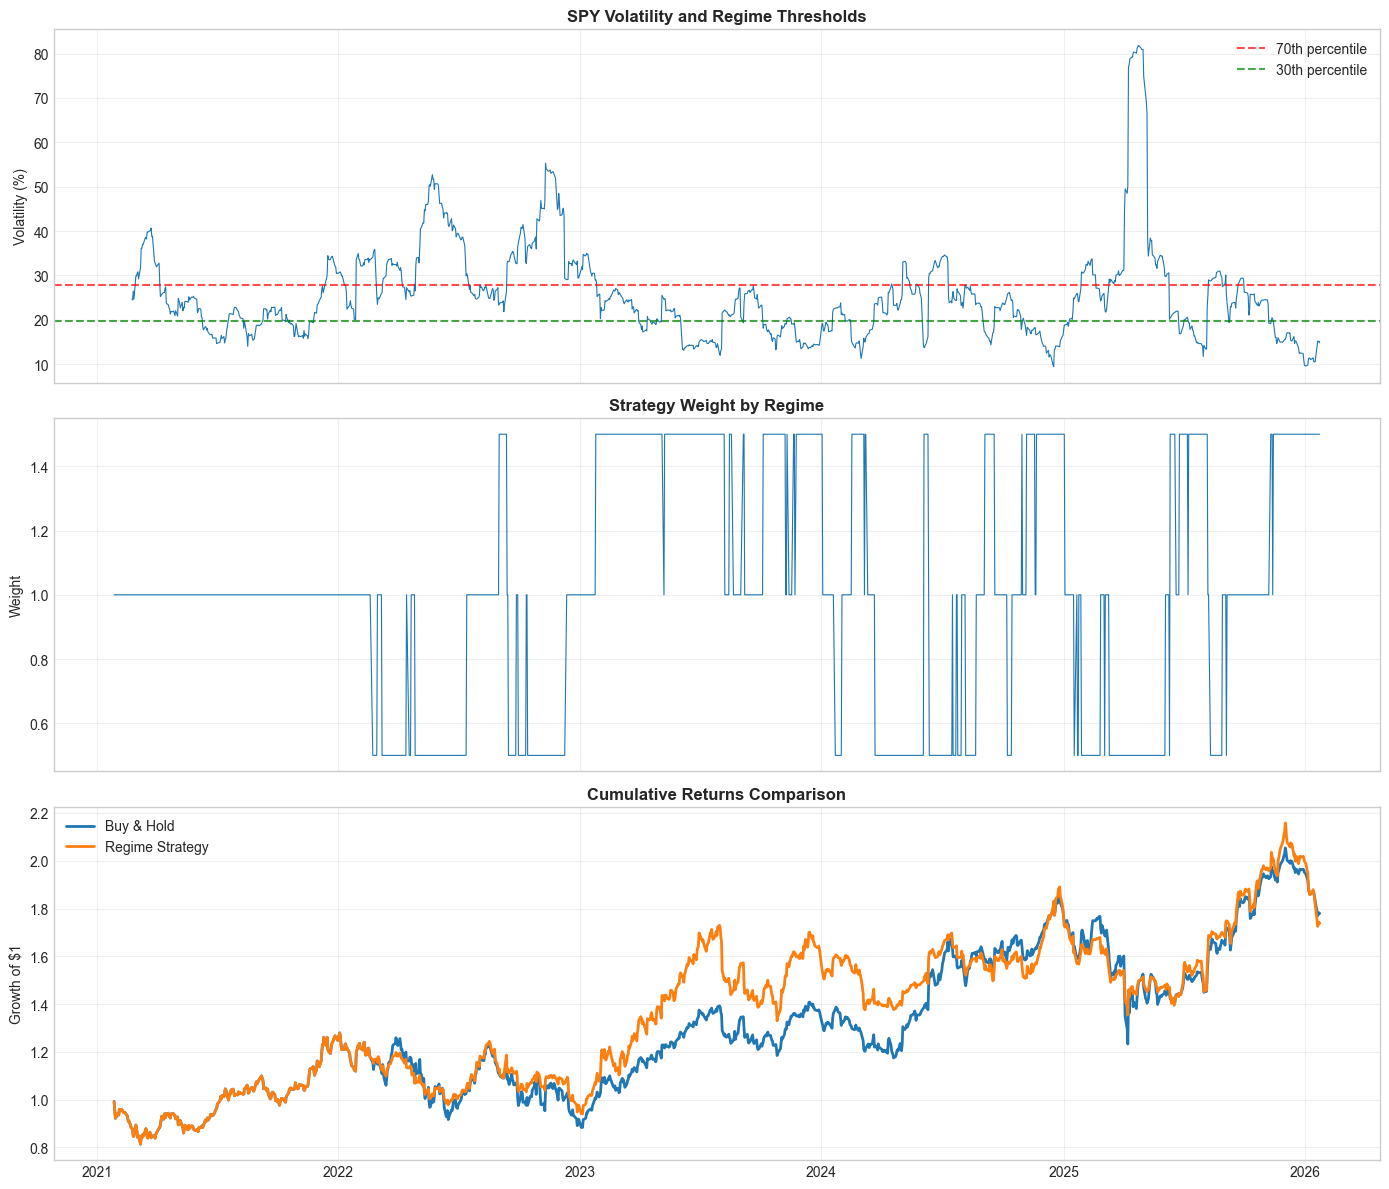

In [7]:
# Plot regime strategy
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

ax1 = axes[0]
ax1.plot(aapl_vol * 100, linewidth=0.8)
ax1.axhline(aapl_vol.quantile(0.7) * 100, color='red', linestyle='--', alpha=0.7, label='70th percentile')
ax1.axhline(aapl_vol.quantile(0.3) * 100, color='green', linestyle='--', alpha=0.7, label='30th percentile')
ax1.set_title('SPY Volatility and Regime Thresholds', fontweight='bold')
ax1.set_ylabel('Volatility (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(weights, linewidth=0.8)
ax2.set_title('Strategy Weight by Regime', fontweight='bold')
ax2.set_ylabel('Weight')
ax2.grid(True, alpha=0.3)

ax3 = axes[2]
ax3.plot((1 + buy_hold_returns).cumprod(), label='Buy & Hold', linewidth=2)
ax3.plot((1 + regime_strategy_returns).cumprod(), label='Regime Strategy', linewidth=2)
ax3.set_title('Cumulative Returns Comparison', fontweight='bold')
ax3.set_ylabel('Growth of $1')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Volatility Targeting

In [8]:
# Target a constant volatility level
target_vol = 0.15  # 15% annualized

# Use GARCH forecast for vol targeting
model = arch_model(aapl_returns * 100, vol='GARCH', p=1, q=1)
result = model.fit(disp='off')
garch_vol = result.conditional_volatility * np.sqrt(TRADING_DAYS) / 100

# Calculate leverage to achieve target vol
leverage = target_vol / garch_vol
leverage = leverage.clip(0.25, 2.0)  # Limit leverage

# Shift for no look-ahead bias
leverage = leverage.shift(1)

# Vol-targeted returns
vol_targeted_returns = aapl_returns * leverage
vol_targeted_returns = vol_targeted_returns.dropna()
aligned_spy = aapl_returns.loc[vol_targeted_returns.index]

print("\n" + "="*60)
print(f"VOLATILITY TARGETING (Target: {target_vol*100:.0f}%)")
print("="*60)

vol_target_results = [
    portfolio_stats(aligned_spy, 'Unlevered SPY'),
    portfolio_stats(vol_targeted_returns, f'Vol Targeted ({target_vol*100:.0f}%)')
]
print(pd.DataFrame(vol_target_results).to_string(index=False))


VOLATILITY TARGETING (Target: 15%)
         Portfolio  Ann. Return (%)  Ann. Vol (%)   Sharpe  Total Return (%)  Max Drawdown (%)
     Unlevered SPY        15.399469     27.684284 0.556253         77.985751        -33.360523
Vol Targeted (15%)         8.735146     15.187073 0.575170         45.834242        -20.055173


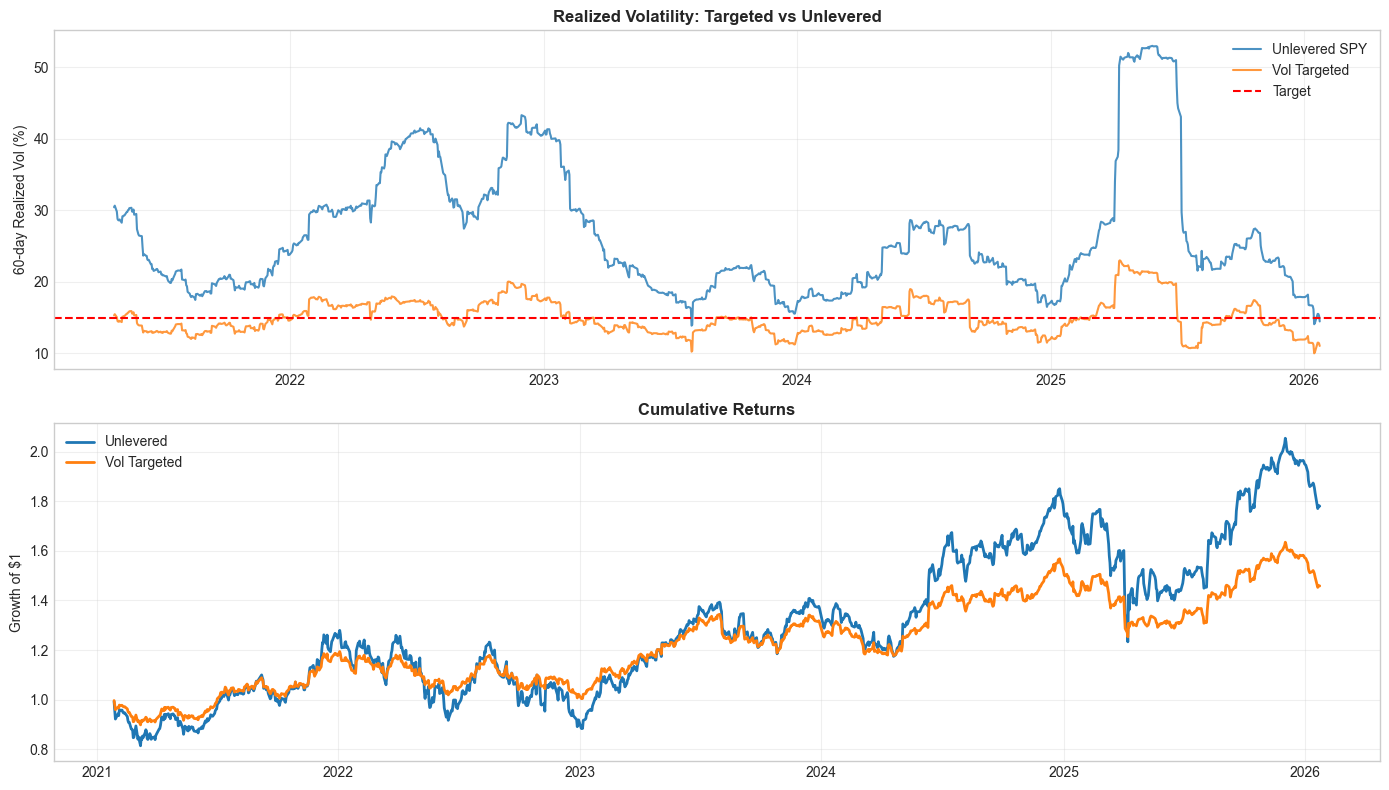

In [9]:
# Compare realized volatility
spy_realized_vol = aligned_spy.rolling(60).std() * np.sqrt(TRADING_DAYS)
targeted_realized_vol = vol_targeted_returns.rolling(60).std() * np.sqrt(TRADING_DAYS)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

ax1 = axes[0]
ax1.plot(spy_realized_vol * 100, label='Unlevered SPY', alpha=0.8)
ax1.plot(targeted_realized_vol * 100, label='Vol Targeted', alpha=0.8)
ax1.axhline(target_vol * 100, color='red', linestyle='--', label='Target')
ax1.set_title('Realized Volatility: Targeted vs Unlevered', fontweight='bold')
ax1.set_ylabel('60-day Realized Vol (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot((1 + aligned_spy).cumprod(), label='Unlevered', linewidth=2)
ax2.plot((1 + vol_targeted_returns).cumprod(), label='Vol Targeted', linewidth=2)
ax2.set_title('Cumulative Returns', fontweight='bold')
ax2.set_ylabel('Growth of $1')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Volatility Risk Premium

In [10]:
# Simulate VRP strategy
# When implied vol > realized vol, sell volatility (go long stocks)
# Here we approximate using GARCH forecast vs realized

# GARCH forecast (proxy for implied)
garch_forecast = garch_vol

# Realized vol
realized_vol = aapl_returns.rolling(20).std() * np.sqrt(TRADING_DAYS)

# VRP signal: forecast - realized
vrp = garch_forecast - realized_vol

# Strategy: long when VRP is positive (sell vol = long stocks)
vrp_signal = (vrp > 0).astype(float)
vrp_signal = vrp_signal.shift(1)  # No look-ahead

vrp_returns = aapl_returns * vrp_signal
vrp_returns = vrp_returns.dropna()
spy_aligned = aapl_returns.loc[vrp_returns.index]

print("\n" + "="*60)
print("VOLATILITY RISK PREMIUM STRATEGY")
print("="*60)

vrp_results = [
    portfolio_stats(spy_aligned, 'Buy & Hold'),
    portfolio_stats(vrp_returns, 'VRP Strategy')
]
print(pd.DataFrame(vrp_results).to_string(index=False))

print(f"\nTime in market: {vrp_signal.mean()*100:.1f}%")


VOLATILITY RISK PREMIUM STRATEGY
   Portfolio  Ann. Return (%)  Ann. Vol (%)   Sharpe  Total Return (%)  Max Drawdown (%)
  Buy & Hold        15.399469     27.684284 0.556253         77.985751        -33.360523
VRP Strategy        20.289990     20.650512 0.982542        147.116103        -19.321097

Time in market: 65.7%


## 5. Strategy Comparison

In [11]:
# Summary of all strategies
print("\n" + "="*70)
print("VOLATILITY STRATEGY SUMMARY")
print("="*70)

all_results = []

# Low vol anomaly
all_results.append(portfolio_stats(low_vol_returns, 'Low Vol Anomaly'))

# Regime strategy
all_results.append(portfolio_stats(regime_strategy_returns, 'Vol Regime'))

# Vol targeting
all_results.append(portfolio_stats(vol_targeted_returns, 'Vol Targeting'))

# VRP
all_results.append(portfolio_stats(vrp_returns, 'VRP'))

summary_df = pd.DataFrame(all_results)
summary_df = summary_df.sort_values('Sharpe', ascending=False)
print(summary_df.to_string(index=False))


VOLATILITY STRATEGY SUMMARY
      Portfolio  Ann. Return (%)  Ann. Vol (%)   Sharpe  Total Return (%)  Max Drawdown (%)
            VRP        20.289990     20.650512 0.982542        147.116103        -19.321097
  Vol Targeting         8.735146     15.187073 0.575170         45.834242        -20.055173
     Vol Regime        14.316761     25.288914 0.566128         73.947909        -28.283509
Low Vol Anomaly        11.809979     24.091915 0.490205         52.550504        -31.120830


## Key Takeaways

1. **Low Volatility Anomaly**: Low vol stocks often have better risk-adjusted returns
2. **Regime Strategies**: Reduce exposure in high vol environments
3. **Volatility Targeting**: Maintains consistent risk exposure over time
4. **VRP Harvesting**: Profit from the premium in implied vs realized vol

### Important Considerations
- **Transaction costs**: Frequent rebalancing can be expensive
- **Leverage limits**: Vol targeting may require leverage
- **Look-ahead bias**: Always shift signals to avoid
- **Regime persistence**: Volatility regimes are somewhat predictable

---
*Next: Day 7 - Interview Questions & Review*

## 🔴 PROS & CONS: Volatility Strategies

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [12]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Volatility Strategies Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-24 11:23

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $248.04
   GOOGL: $327.93
   GS: $918.88
   JPM: $297.72
   MSFT: $465.95

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -9.41%
   🟢 GOOGL: +4.41%
   🟢 GS: +0.89%
   🔴 JPM: -9.15%
   🔴 MSFT: -4.52%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟡 NEUTRAL - Hold current positions
   GS: 🟡 NEUTRAL - Hold current positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🟡 NEUTRAL - Hold current positions

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
